## Imports & Setup

In [123]:
!pip install -e /nsls2/users/alevin/repos/kkcalc

Obtaining file:///nsls2/users/alevin/repos/kkcalc
  Preparing metadata (setup.py) ... done
  Attempting uninstall: kkcalc
    Found existing installation: kkcalc 0.7.5
    Uninstalling kkcalc-0.7.5:
      Successfully uninstalled kkcalc-0.7.5
  Running setup.py develop for kkcalc


In [1]:
# Imports:
import sys
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import xarray as xr
import pandas as pd
import dask.array as da
import kkcalc
from kkcalc import data
from kkcalc import kk
from scipy import optimize
from tqdm.auto import tqdm


sys.path.append('/nsls2/users/alevin/rsoxs_suite/misc_older_work/nexafs_analysis')
import nexafs_fxns as nf  # custom nexafs functions used throughout this notebook

In [2]:
# Define paths

propPath = pathlib.Path('/nsls2/data/sst/proposals/2023-3/pass-313412')
outPath = propPath.joinpath('processed_data')
zarrsPath = outPath.joinpath('zarrs')

In [440]:
# Define functions

# Peter D's kkcalc function for numpy arrays:
def calculate_deltabeta(spectra_e, spectra_abs, chemform, density, e_min=280, e_max=315):
    # Parse chemical formula and calculate formula mass
    stoichiometry = kk.data.ParseChemicalFormula(chemform)
    formula_mass = data.calculate_FormulaMass(stoichiometry)

    # Calculate Atomic Scattering Factors from Henke Database
    ASF_E, ASF_Data = kk.data.calculate_asf(stoichiometry)
    ASF_Data2 = kk.data.coeffs_to_ASF(ASF_E, np.vstack((ASF_Data, ASF_Data[-1])))

    # Merge Henke data with NEXAFS
    merged = data.merge_spectra(np.column_stack((spectra_e, spectra_abs)), ASF_E, ASF_Data, merge_points=(e_min,e_max), add_background=False, fix_distortions=False, plotting_extras=True)

    # Calculate relativistic correction
    correction = kk.calc_relativistic_correction(stoichiometry)

    # Calculate real component of ASF from merged data
    real = kk.KK_PP(merged[2][:,0], merged[0], merged[1], correction)

    
    # Conversion to delta and beta
    delta = data.convert_data(np.column_stack((merged[2][:,0],real)),'ASF','refractive_index', Density=density, Formula_Mass=formula_mass)
    beta = data.convert_data(merged[2],'ASF','refractive_index', Density=density, Formula_Mass=formula_mass)
    
    return delta, beta

#this wrapper function is the same as described in Part 1
#this will accept and return xarrays
def binary_contrast(n1, n2=None):
    if n2 is None:
        #second component is vacuum
        n2 = xr.zeros_like(n1)
    else:
        #second is interpolated to match the energy array of the first component.  
        n2 = n2.interp(energy=n1.energy)
    return n1.energy**4 * ((n1.delta-n2.delta)**2 + (n1.beta-n2.beta)**2)

## Load nexafs datasets from zarrs

In [4]:
sorted([f.name for f in zarrsPath.glob('*')])

['.ipynb_checkpoints',
 'PEY_nexafs_carbon.zarr',
 'PEY_nexafs_nitrogen.zarr',
 'TEY_nexafs_carbon.zarr',
 'TEY_nexafs_nitrogen.zarr',
 'TRMSN_nexafs_carbon_3angle.zarr',
 'TRMSN_nexafs_carbon_day1.zarr',
 'TRMSN_nexafs_nitrogen_3angle.zarr',
 'TRMSN_nexafs_nitrogen_day1.zarr',
 'cartesian_rsoxs_carbon_ncs',
 'cartesian_rsoxs_carbon_rechunked-v2.zarr',
 'cartesian_rsoxs_nitrogen_ncs',
 'cartesian_rsoxs_nitrogen_rechunked-v1.zarr',
 'polar_rsoxs_carbon_ncs',
 'polar_rsoxs_carbon_rechunked-v2.zarr',
 'polar_rsoxs_nitrogen_ncs',
 'polar_rsoxs_nitrogen_rechunked-v1.zarr']

In [249]:
materials_dict = {
    'Y6': ('TEY', 'Y6_CF'),
    'Y6BO': ('TEY', 'Y6BO_CF'),
    'Y7': ('PEY', 'Y7_CB'),
    'Y7BO': ('TEY', 'Y7BO_CB'),
    'PM6' : ('TRMSN', 'PM6_CBCN_rot')
}

In [316]:
plan_of_interst = 'nexafs_carbon'

nf_DA_rows = []
for material, info in tqdm(materials_dict.items()):
    nexafs_type = info[0]
    sample_name = info[1]
    
    if nexafs_type == 'TRMSN':
        nf_DA = xr.open_zarr(zarrsPath.joinpath(f'{nexafs_type}_{plan_of_interest}_3angle.zarr')
                            )[f'full_corr_{nexafs_type.lower()}'].sel(sample_name=[sample_name])        
    else:
        nf_DA = xr.open_zarr(zarrsPath.joinpath(f'{nexafs_type}_{plan_of_interest}.zarr')
                            )[f'full_corr_{nexafs_type.lower()}'].sel(sample_name=[sample_name])
        
    # Drop scan_id and sample_id and compute any dask coordinates
    for coord_name, coord_data in nf_DA.coords.items():
        if coord_name not in nf_DA.dims:
            nf_DA = nf_DA.drop_vars(coord_name)
        elif isinstance(coord_data.data, da.Array):
            nf_DA.coords[coord_name] = coord_data.compute()        
        
        
    nf_DA = nf_DA.assign_coords({'cos_sq_theta': ('theta', ((np.cos(np.deg2rad(nf_DA.theta)))**2).data)})
    nf_DA = nf_DA.interp({'energy': np.linspace(250,350,3000)})   
    nf_DA_rows.append(nf_DA)

  0%|          | 0/5 [00:00<?, ?it/s]

In [348]:
[display(nf_DA) for nf_DA in nf_DA_rows]

<xarray.DataArray 'full_corr_tey' (sample_name: 1, theta: 5, energy: 3000)>
dask.array<chunked_aware_interpnd, shape=(1, 5, 3000), dtype=float64, chunksize=(1, 3, 3000), chunktype=numpy.ndarray>
Coordinates:
  * sample_name   (sample_name) object 'Y6_CF'
  * theta         (theta) int64 20 30 55 70 90
    cos_sq_theta  (theta) float64 0.883 0.75 0.329 0.117 3.749e-33
  * energy        (energy) float64 250.0 250.0 250.1 250.1 ... 349.9 350.0 350.0

<xarray.DataArray 'full_corr_tey' (sample_name: 1, theta: 5, energy: 3000)>
dask.array<chunked_aware_interpnd, shape=(1, 5, 3000), dtype=float64, chunksize=(1, 3, 3000), chunktype=numpy.ndarray>
Coordinates:
  * sample_name   (sample_name) object 'Y6BO_CF'
  * theta         (theta) int64 20 30 55 70 90
    cos_sq_theta  (theta) float64 0.883 0.75 0.329 0.117 3.749e-33
  * energy        (energy) float64 250.0 250.0 250.1 250.1 ... 349.9 350.0 350.0

<xarray.DataArray 'full_corr_pey' (sample_name: 1, theta: 3, energy: 3000)>
dask.array<chunked_aware_interpnd, shape=(1, 3, 3000), dtype=float64, chunksize=(1, 3, 3000), chunktype=numpy.ndarray>
Coordinates:
  * sample_name   (sample_name) object 'Y7_CB'
  * theta         (theta) int64 20 55 90
    cos_sq_theta  (theta) float64 0.883 0.329 3.749e-33
  * energy        (energy) float64 250.0 250.0 250.1 250.1 ... 349.9 350.0 350.0

<xarray.DataArray 'full_corr_tey' (sample_name: 1, theta: 5, energy: 3000)>
dask.array<chunked_aware_interpnd, shape=(1, 5, 3000), dtype=float64, chunksize=(1, 3, 3000), chunktype=numpy.ndarray>
Coordinates:
  * sample_name   (sample_name) object 'Y7BO_CB'
  * theta         (theta) int64 20 30 55 70 90
    cos_sq_theta  (theta) float64 0.883 0.75 0.329 0.117 3.749e-33
  * energy        (energy) float64 250.0 250.0 250.1 250.1 ... 349.9 350.0 350.0

<xarray.DataArray 'full_corr_trmsn' (sample_name: 1, theta: 3, energy: 3000)>
dask.array<chunked_aware_interpnd, shape=(1, 3, 3000), dtype=float64, chunksize=(1, 2, 3000), chunktype=numpy.ndarray>
Coordinates:
  * sample_name   (sample_name) object 'PM6_CBCN_rot'
  * theta         (theta) int64 35 55 90
    cos_sq_theta  (theta) float64 0.671 0.329 3.749e-33
  * energy        (energy) float64 250.0 250.0 250.1 250.1 ... 349.9 350.0 350.0

[None, None, None, None, None]

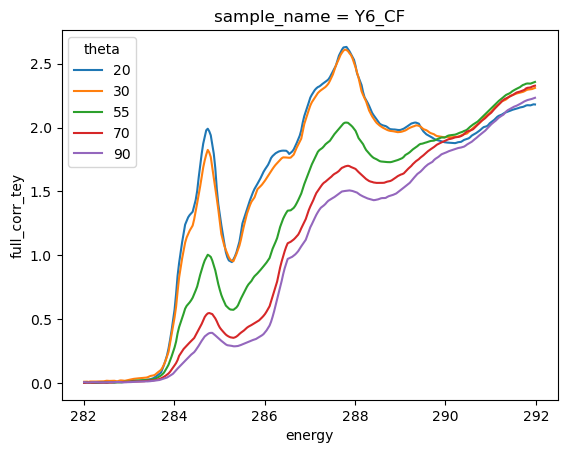

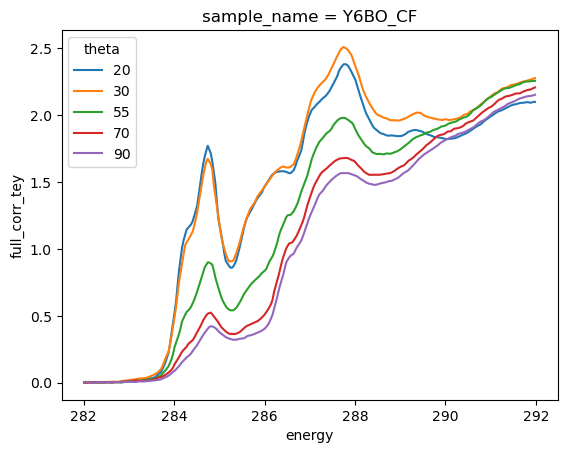

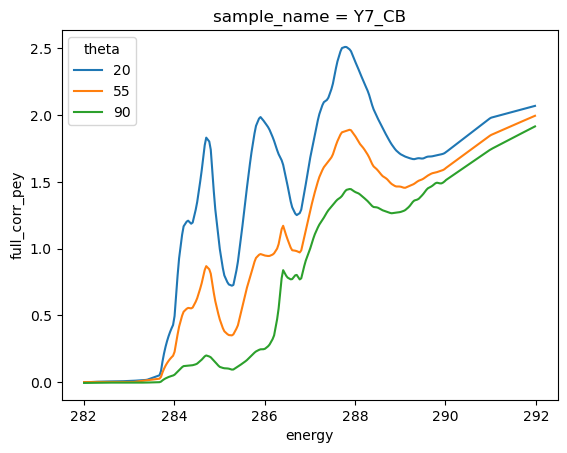

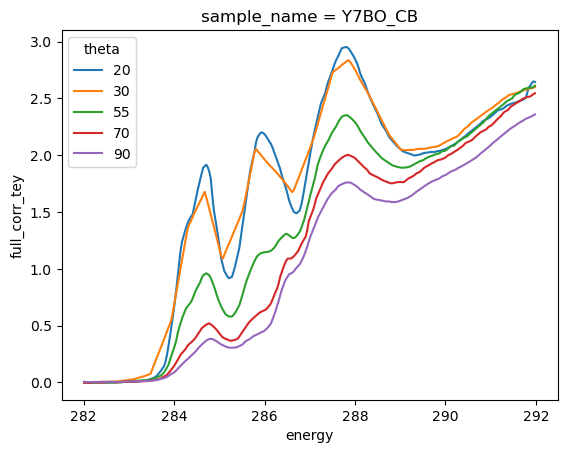

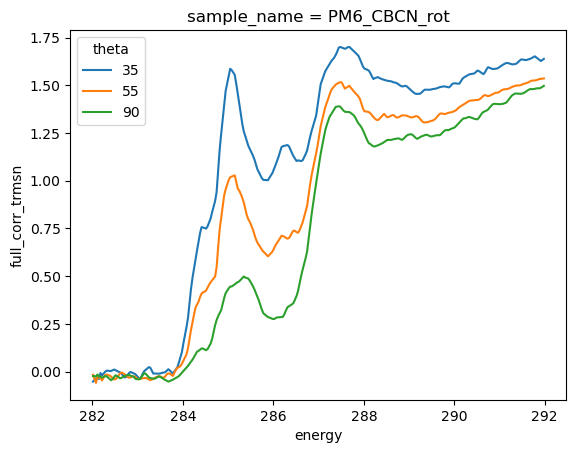

In [351]:
for nf_DA in nf_DA_rows:
    nf_DA.sel(energy=slice(282,292)).plot(hue='theta')
    plt.show()
    plt.close('all')

In [313]:
# plan_of_interest = 'nexafs_carbon'
# loaded_DS = xr.open_zarr(zarrsPath.joinpath(f'TEY_{plan_of_interest}.zarr'))
# # loaded_DS = xr.open_zarr(zarrsPath.joinpath(f'TRMSN_{plan_of_interest}_day1.zarr'))
# # loaded_DS = xr.open_zarr(zarrsPath.joinpath(f'TRMSN_{plan_of_interest}_3angle.zarr'))
# # loaded_DS = xr.open_zarr(zarrsPath.joinpath(f'PEY_{plan_of_interest}.zarr'))

# # Compute any dask coordiantes
# for coord_name, coord_data in loaded_DS.coords.items():
#     if isinstance(coord_data.data, da.Array):
#         loaded_DS.coords[coord_name] = coord_data.compute()

# DS = loaded_DS.copy().assign_coords({'cos_sq_theta': ('theta', ((np.cos(np.deg2rad(loaded_DS.theta)))**2).data)})
# DS

In [314]:
# sample_name = 'Y6_CF'
# DA = DS.sel(sample_name=sample_name)['full_corr_tey']
# DA

## Extrapolate nexafs to theta = 0 

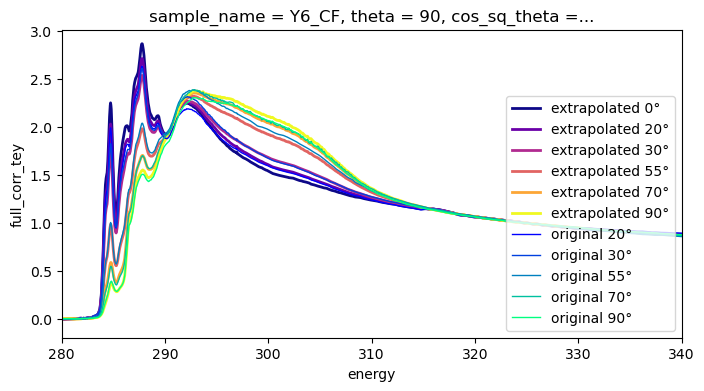

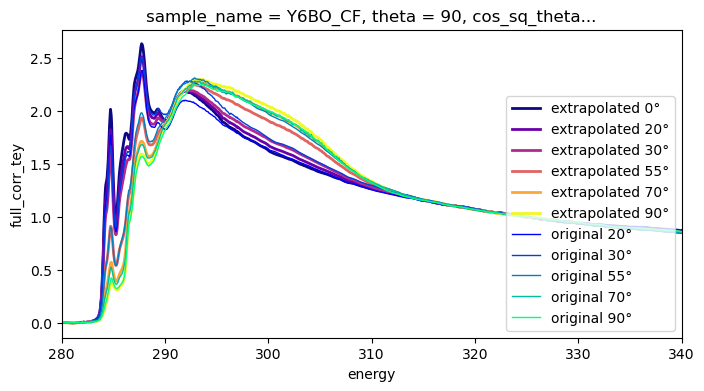

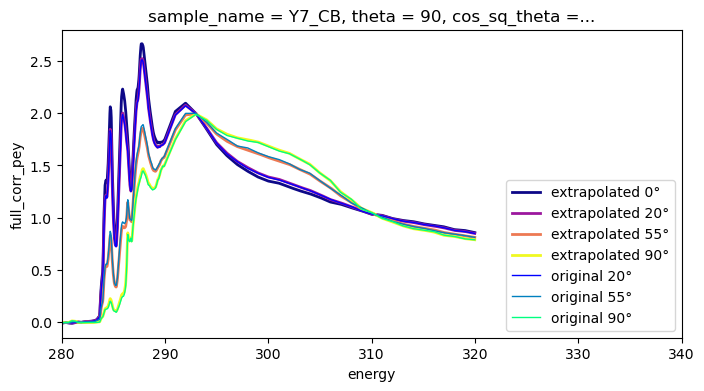

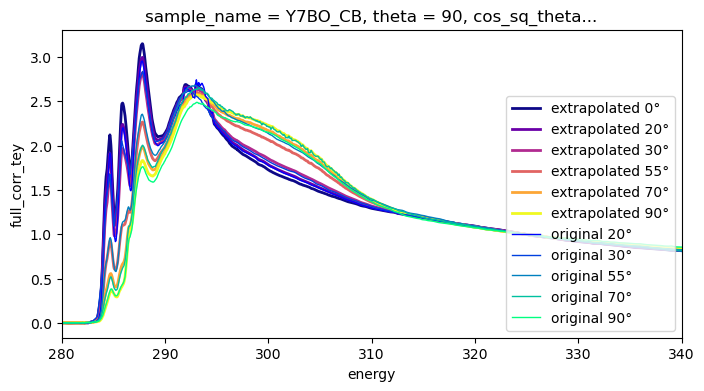

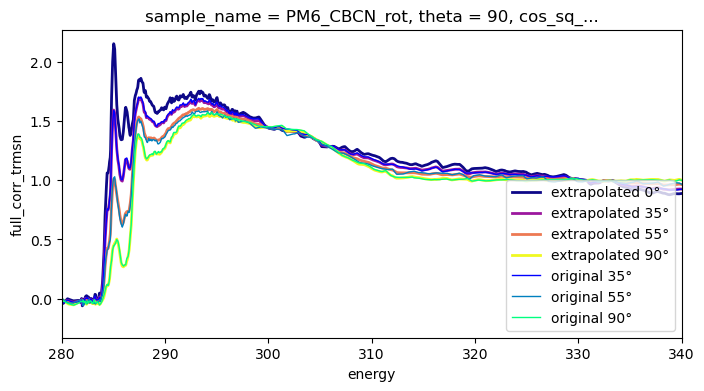

In [341]:
for nf_DA in nf_DA_rows:
    nexafs = nf_DA.copy().swap_dims({'theta':'cos_sq_theta'}).squeeze()
    nexafs_fit = nexafs.polyfit('cos_sq_theta', 1)
    new_theta = np.append(0, nf_DA.theta.values)
    new_cos_sq_theta = (np.cos(new_theta*np.pi/180))**2
    nexafs_ep = nf.evaluate_nexafs_fit(nexafs, nexafs_fit, new_cos_sq_theta, new_theta)   
    
    fig, ax1 = plt.subplots(figsize=(8,4))
    #the xarray way of plotting
    colors = plt.cm.plasma(np.linspace(0,1,nexafs_ep.theta.size))
    colors2 = plt.cm.winter(np.linspace(0,1,nexafs.theta.size))
    for i, cos_sq_theta in enumerate(nexafs_ep.cos_sq_theta): 
        nexafs_ep.electron_yield.sel(cos_sq_theta=cos_sq_theta).plot(color = colors[i], lw = 2, label = f'extrapolated {nexafs_ep.theta[i].values}°')
    for i, cos_sq_theta in enumerate(nexafs.cos_sq_theta): 
        nexafs.sel(cos_sq_theta=cos_sq_theta).plot(color = colors2[i], lw = 1, label = f'original {nexafs.theta[i].values}°')
    # plt.title(nexafs.description)
    ax1.set_xlim(280,340)
    ax1.legend(loc='lower right')
    # plt.savefig(exportPath.joinpath(f'{nexafs_ep.name}_nexafs_theta_extrap.svg'))
    plt.show()
    plt.close('all')

In [342]:
# nexafs = nf_DA_rows[0].copy().swap_dims({'theta':'cos_sq_theta'}).squeeze()

This dielectric function, pretty though it is, still isn't sufficient even to describe the unaxial function of the measured NEXAFS. That is because the extraordinary part of the dielectric function could only be measured by the NEXAFS measurement at $\theta=0$°. There is no experimental geometry that allows $\theta=0$°, so it must be extrapolated.

Intensity should be linear with $cos^2\theta$, so we will fit the nexafs xarray to it. The below xr.polyfit function creates a linear fit function <em>at every energy</em> in the nexafs curve.

In [343]:
# nexafs_fit = nexafs.polyfit('cos_sq_theta', 1)
# new_theta = np.array([0, 20, 30, 55, 70, 90])
# new_cos_sq_theta = (np.cos(new_theta*np.pi/180))**2
# nexafs_ep = nf.evaluate_nexafs_fit(nexafs, nexafs_fit, new_cos_sq_theta, new_theta)

Now that we have a fit at every energy, we'd like to evaluate it. The current xarray implementation of xr.polyval is 'clunky,' to put it mildly.<br>
This function wraps the polyval evaluation and returns a clean nexafs dataset with appropriate metadata. This may be updated or replaced for future versions of xarray.<br>
<ul>nexafs is the original nexafs dataset<br>
nexafs_fit is returned from the polyfit as above<br>
new_cos_sq_theta is an array-like argument of cos_sq_theta values where you want the fit to be evaluated<br>
new_theta is an array-like argument of theta values to assign to those results<br></ul>

In [344]:
# fig, ax1 = plt.subplots(figsize=(8,4))
# #the xarray way of plotting
# colors = plt.cm.plasma(np.linspace(0,1,nexafs_ep.theta.size))
# colors2 = plt.cm.winter(np.linspace(0,1,nexafs.theta.size))
# for i, cos_sq_theta in enumerate(nexafs_ep.cos_sq_theta): 
#     nexafs_ep.electron_yield.sel(cos_sq_theta=cos_sq_theta).plot(color = colors[i], lw = 2, label = f'extrapolated {nexafs_ep.theta[i].values}°')
# for i, cos_sq_theta in enumerate(nexafs.cos_sq_theta): 
#     nexafs.sel(cos_sq_theta=cos_sq_theta).plot(color = colors2[i], lw = 1, label = f'original {nexafs.theta[i].values}°')
# # plt.title(nexafs.description)
# ax1.set_xlim(280,315)
# ax1.legend(loc='lower right')
# # plt.savefig(exportPath.joinpath(f'{nexafs_ep.name}_nexafs_theta_extrap.svg'))
# plt.show()

Note that the extrapolated 90° is very close by the original 90° (this is good. it should be identical), and the extrapolated 0° has a somewhat higher pi* than the original 20°

The extrapolated NEXAFS can be the basis of a uniaxial dielectric function that represents material at the voxel level that is oriented the same as the material in the film.

Note that extrapolation in this manner is mathematically identical to applying a weighted difference spectrum to calculate the expectation at theta=0°. In fact it is superior because difference spectra are typically between two different theta, whereas this linear extrapolation uses all the theta information. We will exploit this sameness more later when extrapolating to the molecular frame. 

## Extrapolating to a "molecular" dielectric function.
But there is more we can do. The molecules at the voxel level may not be limited to the orientation extremes measured on a whole-film basis. The whole film represents an ensemble and is likely never similar to what an individual molecule or voxel is capable of unless it is sigle crystal like highly oriented pyrolytic graphite (HOPG). To develop a "molecular" dielectric function, we must manipulate the NEXAFS beyond what was measured. 

This manipulation requires making an assumption about how one or more resonances should behave with energy; implicit in this assumption is typically an assumption about the conformation of the molecule.

For this exercise we will assume that the molecule Y6 has a rigid and planar conjugated structure, such that the pi* resonances should follow Stohr 9.16a for $\alpha=0$°


The function below develops a mean squared error for the area between e_min and e_max for a specific extrapolation of the nexafs curves, and a target area. The target area will be developed from our knowledge of how I should vary with $\alpha$ and $\theta$ described above.<br>
Note there is an additional contributor to mse below: if the extrapolation produces negative values for absorbance it imposes a stiff penalty because such values are unphysical.

In [345]:
def mse(cos_sq_theta, e_min, e_max, nexafs, nexafs_fit, targ):
    #compose new extrapolated nexafs based on proposed cos_sq_theta 
    nexafs_new = nf.evaluate_nexafs_fit(nexafs, nexafs_fit, [cos_sq_theta[0]], [0])
    #evaluate the difference in area between the extrapolated nexafs and the taget targ
    mse = (nf.int_area(e_min, e_max, nexafs_new.electron_yield)-targ)**2
    minval = nexafs_new.sel(energy = slice(e_min,e_max)).electron_yield.min().values
    if minval < 0: #impose penalty for negative absorbance values
        mse = 1E10*mse*(-minval)
    return mse

In [390]:
cossqtheta_o_rows = []
cossqtheta_e_rows = []
magic_nf_rows = []

for nf_DA in tqdm(nf_DA_rows): 
    sample_name = nf_DA.sample_name.values[0]
    
    nexafs = nf_DA.copy().swap_dims({'theta':'cos_sq_theta'}).squeeze()
    nexafs_fit = nexafs.polyfit('cos_sq_theta', 1)
    
    e_min = 283.5  
    # e_max = 285.3  # acceptor
    e_max = 286 if 'PM6' in sample_name else 285.3
    res_o = optimize.differential_evolution(mse, [(-1, 1)], args = (e_min, e_max, nexafs, nexafs_fit, 0), tol=1e-6)
    cossqtheta_o = float(res_o.x)
    cossqtheta_o_rows.append(cossqtheta_o)
    
    magic_nf = nf.evaluate_nexafs_fit(nexafs, nexafs_fit, [0.329], [55]).electron_yield
    magic_nf_rows.append(magic_nf)
    
    magic_int = nf.int_area(e_min, e_max, magic_nf)
    ord_int = nf.int_area(e_min, e_max, nf.evaluate_nexafs_fit(nexafs, nexafs_fit, [cos_sq_theta_mol_o], [0]).electron_yield)
    e_targ = magic_int + 2*(magic_int-ord_int)

    # For perfectly face on, the extraordinary intensity should be exactly 3x magic intensity
    # This fit tends to be faster
    res_e = optimize.minimize(mse, 1, method='Nelder-Mead', args = (e_min, e_max, nexafs, nexafs_fit, e_targ), tol=1e-6)
    cossqtheta_e = float(res_e.x)    
    cossqtheta_e_rows.append(cossqtheta_e)
    

  0%|          | 0/5 [00:00<?, ?it/s]

In [488]:
# nf_mol_DA_rows = []

# for i, mol_fits in enumerate(zip(cossqtheta_o_rows, cossqtheta_e_rows)):
#     mol_fits = list(mol_fits)
    
#     nf_DA = nf_DA_rows[i]
#     magic_nf_DA = magic_nf_rows[i].swap_dims({'cos_sq_theta':'theta'})
    
#     sample_name = nf_DA.sample_name.values[0]
#     nexafs = nf_DA.copy().swap_dims({'theta':'cos_sq_theta'}).squeeze()
#     nexafs_fit = nexafs.polyfit('cos_sq_theta', 1)
    
#     nexafs_mol = nf.evaluate_nexafs_fit(nexafs, nexafs_fit, mol_fits, [90, 0])

#     nf_mol_DA = nexafs_mol.electron_yield.swap_dims({'cos_sq_theta':'theta'}).rename('extrap_mol_nexafs')
#     nf_mol_DA = xr.concat([nf_mol_DA, magic_nf_DA], dim='theta').sortby('theta')
#     nf_mol_DA = nf_mol_DA.expand_dims({'sample_name': [sample_name]})
#     nf_mol_DA_rows.append(nf_mol_DA)

In [480]:
# do this for a finely spaced values of theta...

nf_mol_DA_rows = []

for i, mol_fits in enumerate(zip(cossqtheta_o_rows, cossqtheta_e_rows)):
    mol_fits = list(mol_fits)
    
    fine_mol_fits = np.linspace(mol_fits[0], mol_fits[1], 100)
    fine_theta = np.linspace(90, 0, 100)
    
    nf_DA = nf_DA_rows[i]
    magic_nf_DA = magic_nf_rows[i].swap_dims({'cos_sq_theta':'theta'})
    
    sample_name = nf_DA.sample_name.values[0]
    nexafs = nf_DA.copy().swap_dims({'theta':'cos_sq_theta'}).squeeze()
    nexafs_fit = nexafs.polyfit('cos_sq_theta', 1)
    
    nexafs_mol = nf.evaluate_nexafs_fit(nexafs, nexafs_fit, fine_mol_fits, fine_theta)

    nf_mol_DA = nexafs_mol.electron_yield.swap_dims({'cos_sq_theta':'theta'}).rename('extrap_mol_nexafs')
    # nf_mol_DA = xr.concat([nf_mol_DA, magic_nf_DA], dim='theta').sortby('theta')
    nf_mol_DA = nf_mol_DA.expand_dims({'sample_name': [sample_name]})
    nf_mol_DA_rows.append(nf_mol_DA)

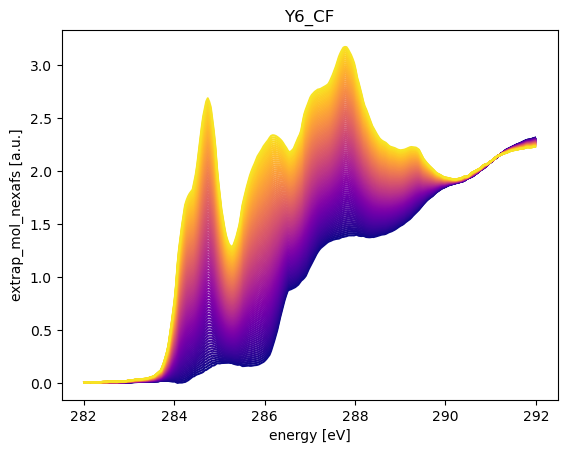

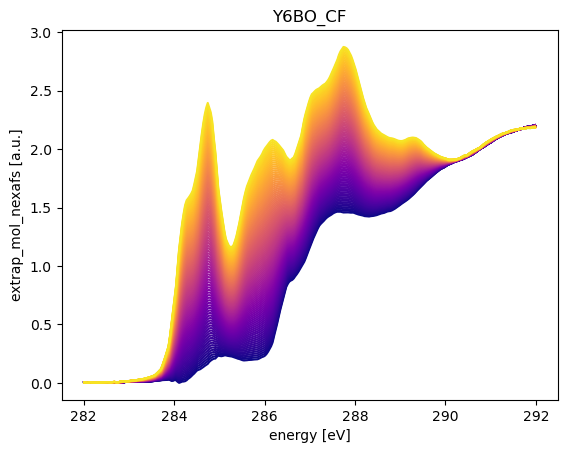

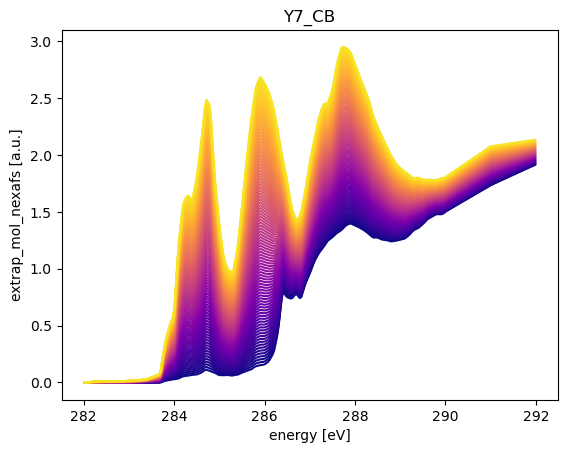

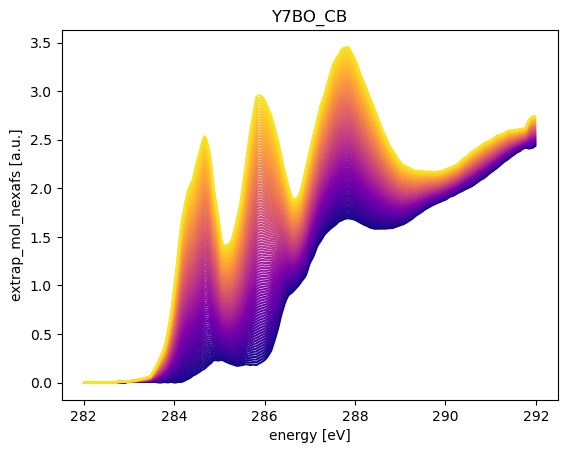

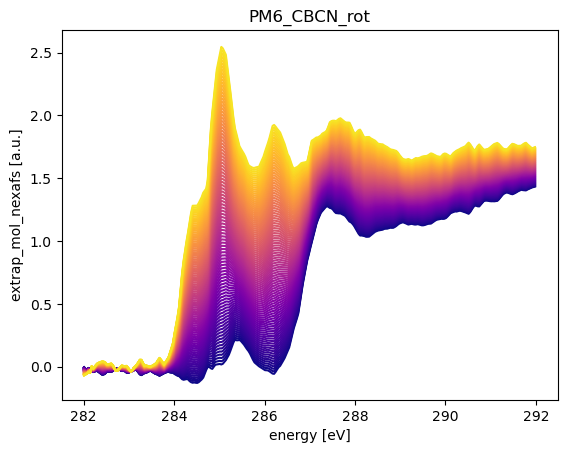

In [487]:
colors = plt.cm.plasma(np.linspace(0,0.95,len(nf_mol_DA_rows[0].theta)))
                       
for nf_mol_DA in nf_mol_DA_rows:
    for i, theta_val in enumerate(nf_mol_DA.theta.values):
        nf_mol_DA.sel(energy=slice(282,292), theta=theta_val).plot(color=colors[i])
    plt.title(nf_mol_DA.sample_name.values[0])
    plt.show()
    plt.close('all')

For our first fit, we will attempt to make the pi* manifold absorbance zero; this would correspond to $\alpha=0, \theta=90$° (Ordinary)

In [425]:
# # These are integration bounds; we will extrapolate to "perfect" values of integrated intensity within these bounds
# # which bound you choose will adjust the result slightly.

# # This step may take a while to complete

# e_min = 283.5  # acceptor
# e_max = 285.3  # acceptor
# res = optimize.differential_evolution(mse, [(-1, 1)], args = (e_min, e_max, nexafs, nexafs_fit, 0), tol=1e-6)
# cos_sq_theta_mol_o = float(res.x)

For the next fit, we will attempt to make the pi* manifold maximized to correspond to $\alpha=0, \theta=0$°. (Extraordinary) <br> For a perfectly oriented $\alpha = 0$° molecule, the target would be exactly 3x the magic intensity. But our fit prefers some small amount of intensity so that absorbance doesn't go below zero. We will instead determine our target using the math above:<br><br>
$\displaystyle\frac{I(90) - I(54.7)}{I(0) - I(54.7)} = \frac{\frac{1}{3}[1+(3cos^2\alpha-1)]-\frac{1}{3}}{\frac{1}{3}[1-\frac{1}{2}(3cos^2\alpha-1)] - \frac{1}{3}} =-2$


In [426]:
# magic_int = nf.int_area(e_min, e_max, nf.evaluate_nexafs_fit(nexafs, nexafs_fit, [0.329], [0]).electron_yield)
# ord_int = nf.int_area(e_min, e_max, nf.evaluate_nexafs_fit(nexafs, nexafs_fit, [cos_sq_theta_mol_o], [0]).electron_yield)
# e_targ = magic_int + 2*(magic_int-ord_int)

# # For perfectly face on, the extraordinary intensity should be exactly 3x magic intensity
# # This fit tends to be faster
# res = optimize.minimize(mse, 1, method='Nelder-Mead', args = (e_min, e_max, nexafs, nexafs_fit, e_targ), tol=1e-6)
# cos_sq_theta_mol_e = float(res.x)

In [427]:
# mol_fits = [cos_sq_theta_mol_e, cos_sq_theta_mol_o]
# nexafs_mol = nf.evaluate_nexafs_fit(nexafs, nexafs_fit, mol_fits, [0, 90])

# nf_mol_DA = nexafs_mol.electron_yield.swap_dims({'cos_sq_theta':'theta'})
# nf_mol_DA = xr.concat([nf_mol_DA, DA.sel(theta=55)], dim='theta').sortby('theta')

# nf_mol_DA.sel(energy=slice(282,292)).plot(hue='theta')
# plt.show()

## Calculate optical constants 

In [489]:
Y6_formula = 'C82H86F4N8O2S5'
Y7_formula = 'C82H86Cl4N8O2S5'
PM6_formula = 'C68H76F2O2S8'

In [141]:
# Older code for kkcalc transformation, seems to be a bit different than the newer numpy way. The deltas it generates seem to not being going as low as they should be

# oc_DS = nf.run_kkcalc_a(nf_mol_DA, x_min = 270, x_max = 340, chemical_formula = Y6_formula, density = 1.1).swap_dims({'cos_sq_theta':'theta'})

In [503]:
density = 1.1

oc_DS_rows = []

for nf_mol_DA in tqdm(nf_mol_DA_rows):
    sample_name = nf_mol_DA.sample_name.values[0]
    
    if 'Y6' in sample_name: 
        chemform = Y6_formula
    elif 'Y7' in sample_name:
        chemform = Y7_formula
    elif 'PM6' in sample_name:
        chemform = PM6_formula
    else:
        print("Error, no chemical formula set")
        break

    delta_DA_rows = []
    beta_DA_rows = []

    for theta_val in nf_mol_DA.theta.values:
        nf_DA = nf_mol_DA.squeeze().sel(theta=theta_val).compute()
        spectra_e = nf_DA.energy.data
        spectra_abs = nf_DA.data

        delta, beta = calculate_deltabeta(spectra_e, spectra_abs, chemform, density)

        delta_DA = nf_DA.copy().rename('delta')
        delta_DA.data = delta[:,1]
        delta_DA = delta_DA.expand_dims('theta')
        delta_DA_rows.append(delta_DA)

        beta_DA = nf_DA.copy().rename('beta')
        beta_DA.data = beta[:,1]
        beta_DA = beta_DA.expand_dims('theta')
        beta_DA_rows.append(beta_DA)


    samp_oc_DS = xr.concat(delta_DA_rows, dim='theta').to_dataset()
    samp_oc_DS['beta'] = xr.concat(beta_DA_rows, dim='theta')
    samp_oc_DS['vacuum_contrast'] = binary_contrast(samp_oc_DS)
    oc_DS_rows.append(samp_oc_DS.expand_dims('sample_name'))
    
oc_DS = xr.concat(oc_DS_rows, dim='sample_name').sortby('sample_name').sortby('theta')
oc_DS

  0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 

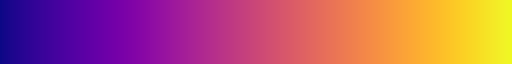

In [511]:
plt.cm.plasma

In [513]:
oc_DS = oc_DS.sortby('theta')

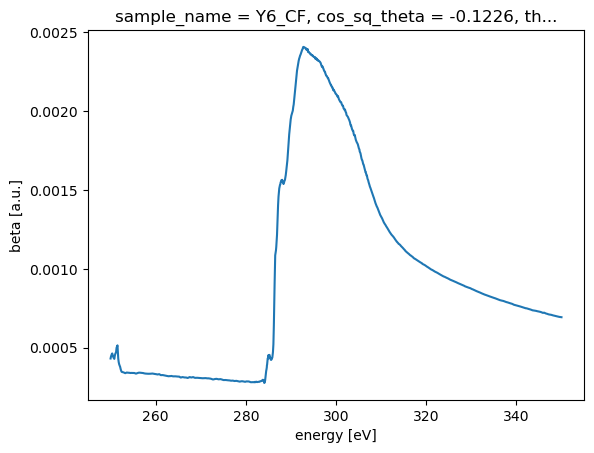

In [519]:
oc_DS['beta'].sel(sample_name='Y6_CF').sel(theta=90,method='nearest').plot()

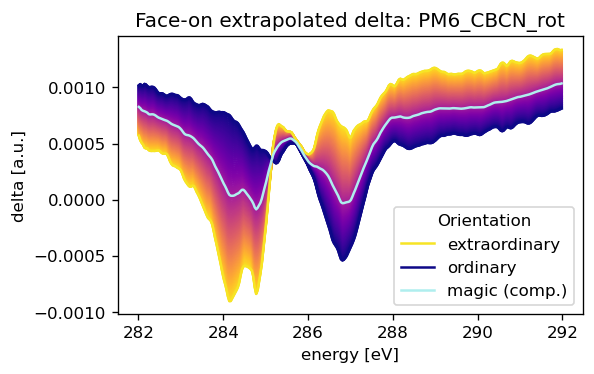

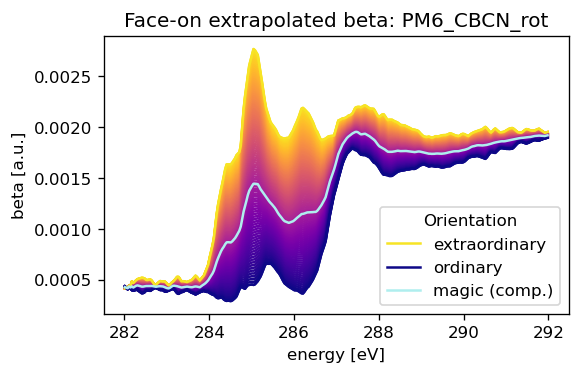

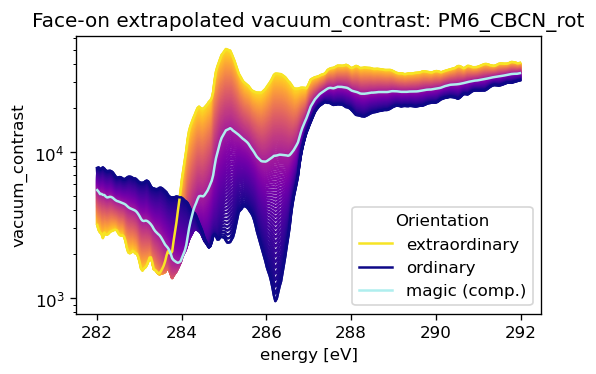

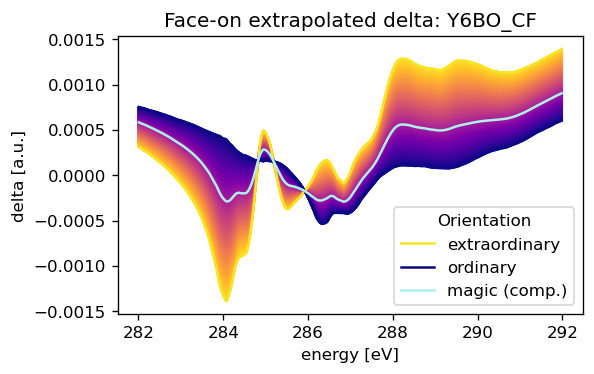

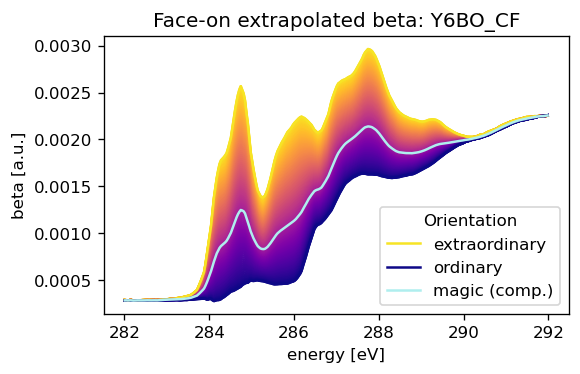

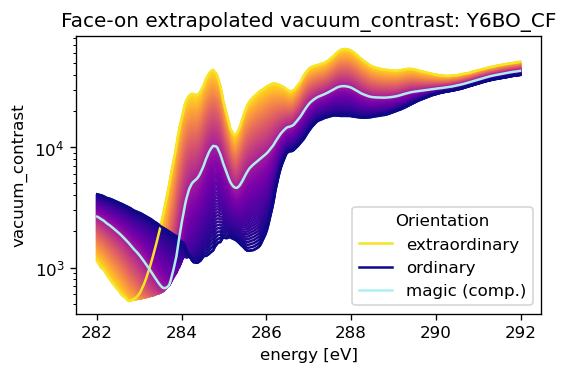

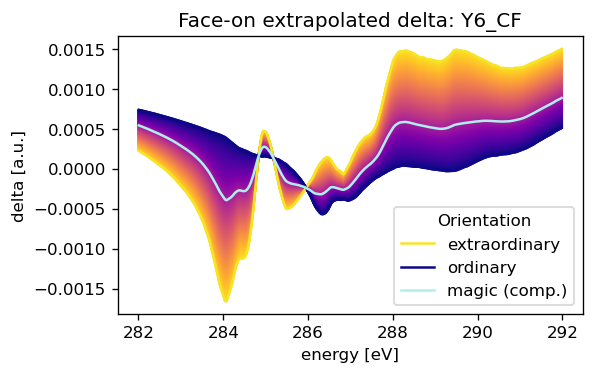

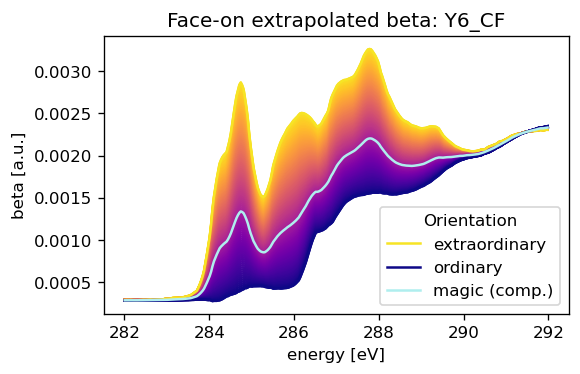

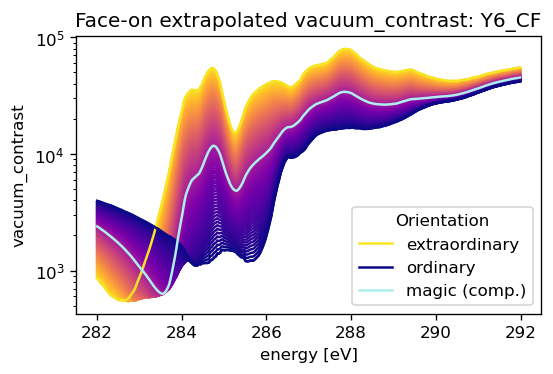

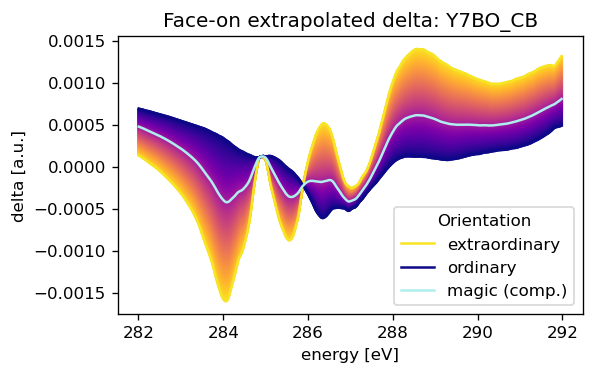

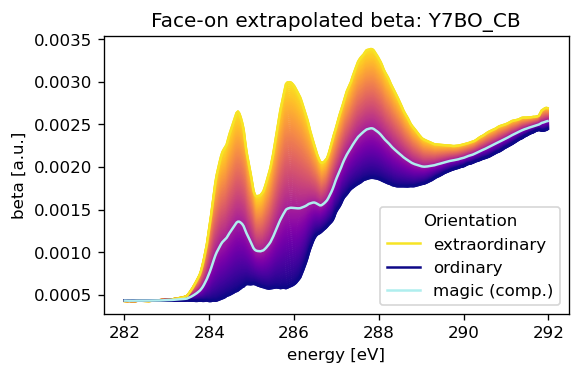

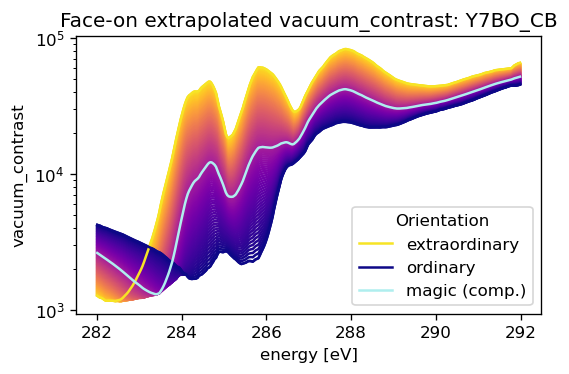

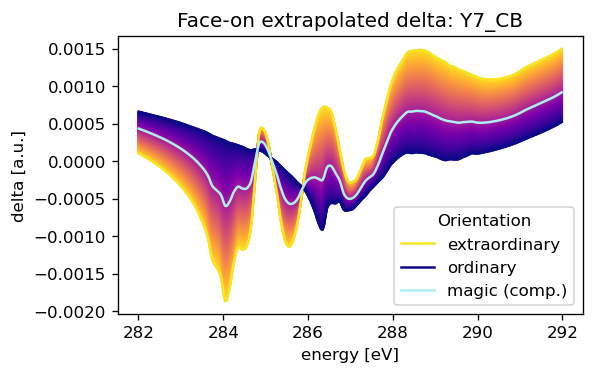

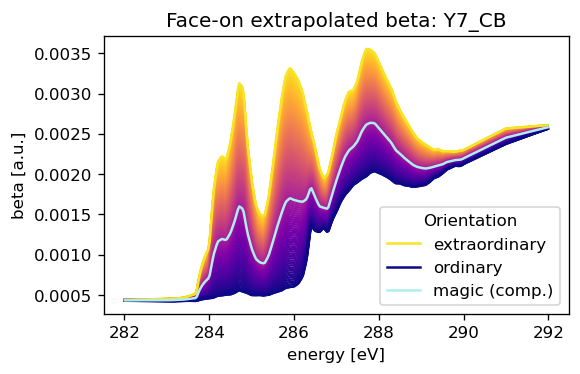

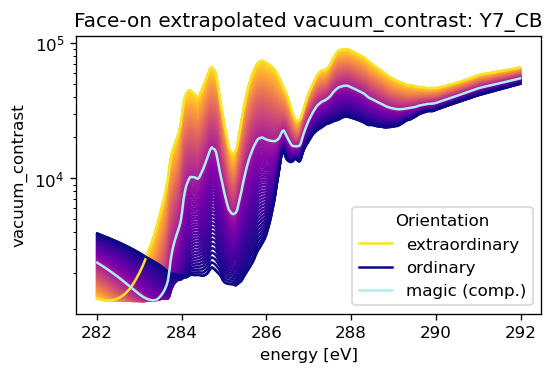

In [527]:
colors = plt.cm.plasma_r(np.linspace(0.05,1,len(oc_DS.theta)))
# sample_name = str(oc_DS.sample_name.values)

for sample_name in oc_DS.sample_name.values:
    samp_oc_DS = oc_DS.sel(sample_name=sample_name)
    
    for data_var in ['delta', 'beta', 'vacuum_contrast']:
        
        yscale = 'log' if data_var == 'vacuum_contrast' else 'linear'
        
        for energy_slice in [slice(282,292)]:
            fig, ax = plt.subplots(figsize=(5,3), dpi=120)
            for i, theta_val in enumerate(oc_DS.theta.values):
                samp_oc_DS[data_var].sel(theta=theta_val, energy=energy_slice).plot(ax=ax, color=colors[i])

            samp_oc_DS[data_var].sel(theta=0, method='nearest').sel(energy=energy_slice).plot(ax=ax, color=colors[0], label='extraordinary')
            samp_oc_DS[data_var].sel(theta=90, method='nearest').sel(energy=energy_slice).plot(ax=ax, color=colors[-1], label='ordinary')
            samp_oc_DS[data_var].sel(theta=55, method='nearest').sel(energy=energy_slice).plot(ax=ax, color='paleturquoise', label='magic (comp.)')
            ax.set(title=f'Face-on extrapolated {data_var}: {sample_name}', yscale=yscale)
            ax.legend(title='Orientation', loc='lower right')
            plt.show()
            plt.close('all')

## Save optical constants dataset as zarr

In [494]:
oc_DS

<xarray.Dataset>
Dimensions:          (sample_name: 5, theta: 100, energy: 3000)
Coordinates:
  * sample_name      (sample_name) <U12 'PM6_CBCN_rot' 'Y6BO_CF' ... 'Y7_CB'
    cos_sq_theta     (sample_name, theta) float64 -0.2549 -0.2398 ... 1.232
  * theta            (theta) float64 90.0 89.09 88.18 87.27 ... 1.818 0.9091 0.0
  * energy           (energy) float64 250.0 250.0 250.1 ... 349.9 350.0 350.0
Data variables:
    delta            (sample_name, theta, energy) float64 0.002236 ... 0.001614
    beta             (sample_name, theta, energy) float64 0.0003842 ... nan
    vacuum_contrast  (sample_name, energy, theta) float64 2.011e+04 ... nan

In [495]:
zarrsPath

PosixPath('/nsls2/data/sst/proposals/2023-3/pass-313412/processed_data/zarrs')

In [496]:
oc_DS.to_zarr(zarrsPath.joinpath(f'material_optical_constants.zarr'), mode='w')

In [525]:
# xr.open_zarr(zarrsPath.joinpath(f'material_optical_constants.zarr')).sel(sample_name='PM6_CBCN_rot')['vacuum_contrast'].plot(yscale='log', hue='theta')
# plt.show()

In [455]:
# density = 1.1
# chemform = Y6_formula

# delta_DA_rows = []
# beta_DA_rows = []

# for theta_val in tqdm(nf_mol_DA.theta.values):
#     nf_DA = nf_mol_DA.squeeze().sel(theta=theta_val).compute()
#     spectra_e = nf_DA.energy.data
#     spectra_abs = nf_DA.data
    
#     delta, beta = calculate_deltabeta(spectra_e, spectra_abs, chemform, density)
    
#     delta_DA = nf_DA.copy().rename('delta')
#     delta_DA.data = delta[:,1]
#     delta_DA = delta_DA.expand_dims('theta')
#     delta_DA_rows.append(delta_DA)

#     beta_DA = nf_DA.copy().rename('beta')
#     beta_DA.data = beta[:,1]
#     beta_DA = beta_DA.expand_dims('theta')
#     beta_DA_rows.append(beta_DA)

    
# oc_DS = xr.concat(delta_DA_rows, dim='theta').to_dataset()
# oc_DS['beta'] = xr.concat(beta_DA_rows, dim='theta')
# oc_DS['vacuum_contrast'] = binary_contrast(oc_DS)
# oc_DS

In [456]:
# colors = plt.cm.plasma_r(np.linspace(0.15,1,len(oc_DA.theta)))
# sample_name = str(oc_DS.sample_name.values)

# for data_var in ['delta', 'beta', 'vacuum_contrast']:
#     yscale = 'log' if data_var == 'vacuum_contrast' else 'linear'

#     for energy_slice in [slice(None,None), slice(282,292)]:
#         fig, ax = plt.subplots(figsize=(5,3), dpi=120)
#         for i, theta_val in enumerate(oc_DS.theta.values):
#             oc_DS[data_var].sel(theta=theta_val, energy=energy_slice).plot(ax=ax, color=colors[i], label=theta_val)

#         ax.set(title=f'Face-on extrapolated {data_var}: {sample_name}', yscale=yscale)
#         ax.legend(title='Theta [°]', loc='lower right')
#         plt.show()

In [457]:
# colors = plt.cm.plasma_r(np.linspace(0.15, 1, len(oc_DA.theta)))
# sample_name = str(oc_DS.sample_name.values)

# for data_var in ['delta', 'beta', 'vacuum_contrast']:
#     yscale = 'log' if data_var == 'vacuum_contrast' else 'linear'

#     for energy_slice in [slice(None, None), slice(282, 292)]:
#         fig, ax = plt.subplots(figsize=(5, 3), dpi=120)
#         for i, theta_val in enumerate(oc_DS.theta.values):
#             oc_DS[data_var].sel(theta=theta_val, energy=energy_slice).plot(ax=ax, color=colors[i], label=theta_val)

#         ax.set(title=f'Face-on extrapolated {data_var}: {sample_name}', yscale=yscale)
#         ax.legend(title='Theta [°]', loc='lower right')
#         plt.subplots_adjust(bottom=0.2, left=0.2)
#         fig.savefig(f'{sample_name}_{data_var}_{energy_slice.start}-{energy_slice.stop}.png',dpi=120)
#         plt.show()
#         plt.close('all')
